In [1]:
from google.colab import files
uploaded = files.upload()

Saving 2nd source - XAUUSD_H4 Update data.csv to 2nd source - XAUUSD_H4 Update data.csv


In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
import lightgbm as lgb
from collections import Counter


In [3]:
# Load Dataset
df = pd.read_csv("2nd source - XAUUSD_H4 Update data.csv")
df.columns = df.columns.str.strip()

# Target: 1 if Close > Open else 0
df["Result"] = (df["Close"].shift(-1) > df["Open"].shift(-1)).astype(int)
df = df.dropna(subset=["Result"])




In [4]:
df["datetime"] = pd.to_datetime(df["Date"] + " " + df["Candel Time"] + " " + df["AM/PM"])
df = df.set_index("datetime")
df = df.sort_index()
df = df.drop(columns=["Date", "Candel Time", "AM/PM"])
df.head()

/tmp/ipython-input-3913295151.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df["datetime"] = pd.to_datetime(df["Date"] + " " + df["Candel Time"] + " " + df["AM/PM"])


,Open,High,Low,Close,Volume,price_change,Result
datetime,,,,,,,
2009-01-02 20:00:00,926.769,926.870,920.569,923.671,79,-3.098,0
2009-01-03 20:00:00,939.644,948.750,937.722,947.949,85,8.305,1
2009-01-04 00:00:00,918.729,921.712,917.520,920.903,230,2.174,0
2009-01-04 04:00:00,920.775,920.899,916.184,917.922,238,-2.853,1
2009-01-04 08:00:00,918.012,928.700,916.521,925.817,239,7.805,0


In [5]:
# ==============================
# Feature Engineering for Gold/XAUUSD Prediction
# Leakage-free for time-series models
# ==============================

# -----------------------------
# 1️⃣ Ensure datetime index
# -----------------------------
df.index = pd.to_datetime(df.index)

# -----------------------------
# 2️⃣ Time features
# -----------------------------
df["hour"]    = df.index.hour
df["weekday"] = df.index.weekday
df["month"]   = df.index.month
df["session"] = df["hour"].apply(lambda h: 1 if 7<=h<=16 else 2 if 17<=h<=23 else 3)

# -----------------------------
# 3️⃣ Lag features (1 to 5 candles)
# -----------------------------
for lag in range(1, 6):
    df[f"prev_open_{lag}"]   = df["Open"].shift(lag)
    df[f"prev_high_{lag}"]   = df["High"].shift(lag)
    df[f"prev_low_{lag}"]    = df["Low"].shift(lag)
    df[f"prev_close_{lag}"]  = df["Close"].shift(lag)
    df[f"prev_volume_{lag}"] = df["Volume"].shift(lag)
    df[f"return_{lag}"]      = df["Close"].pct_change(lag)

# -----------------------------
# 4️⃣ Rolling mean & std
# -----------------------------
for window in [3, 5, 10, 20]:
    df[f"ma_{window}"]  = df["Close"].shift(1).rolling(window).mean()
    df[f"std_{window}"] = df["Close"].shift(1).rolling(window).std()

# -----------------------------
# 5️⃣ EMA features
# -----------------------------
for span in [10, 50]:
    df[f"EMA_{span}"] = df["Close"].shift(1).ewm(span=span, adjust=False).mean()

# -----------------------------
# 6️⃣ RSI (14 period)
# -----------------------------
delta = df["Close"].diff()
gain  = (delta.where(delta>0, 0)).shift(1).rolling(14).mean()
loss  = (-delta.where(delta<0, 0)).shift(1).rolling(14).mean()
rs    = gain / (loss + 1e-9)
df["RSI_14"] = 100 - (100 / (1 + rs))

# -----------------------------
# 7️⃣ MACD (12-26 EMA) and MACD signal
# -----------------------------
ema12 = df["Close"].shift(1).ewm(span=12, adjust=False).mean()
ema26 = df["Close"].shift(1).ewm(span=26, adjust=False).mean()
df["MACD"]        = ema12 - ema26
df["MACD_signal"] = df["MACD"].ewm(span=9, adjust=False).mean().shift(1)

# -----------------------------
# 8️⃣ Candle shape & volatility
# -----------------------------
df["range"]       = (df["High"] - df["Low"]).shift(1)
df["body"]        = (df["Close"] - df["Open"]).shift(1)
df["upper_wick"]  = df["High"] - df[["Close","Open"]].max(axis=1).shift(1)
df["lower_wick"]  = df[["Close","Open"]].min(axis=1) - df["Low"].shift(1)

# -----------------------------
# 9️⃣ ATR (Average True Range)
# -----------------------------
high_low  = df["High"] - df["Low"]
high_close = (df["High"] - df["Close"].shift(1)).abs()
low_close  = (df["Low"] - df["Close"].shift(1)).abs()
df["ATR_14"] = pd.concat([high_low, high_close, low_close], axis=1).max(axis=1).shift(1).rolling(14).mean()

# -----------------------------
# 🔟 Momentum & Stochastic Oscillator
# -----------------------------
# Momentum (5 periods)
df['momentum_5'] = df['Close'].shift(1) - df['Close'].shift(6)

# Stochastic %K (14 periods)
low_min  = df['Low'].shift(1).rolling(14).min()
high_max = df['High'].shift(1).rolling(14).max()
df['stoch_k'] = 100 * (df['Close'].shift(1) - low_min) / (high_max - low_min + 1e-9)

# -----------------------------
# 1️⃣1️⃣ Volume features
# -----------------------------
df['vol_ma_5']      = df['Volume'].shift(1).rolling(5).mean()
df['vol_change_1']  = df['Volume'].pct_change().shift(1)

# -----------------------------
# 1️⃣2️⃣ Remove any rows with NaN (from lag/rolling/shift)
# -----------------------------
df = df.dropna()

# -----------------------------
# ✅ Final check
# -----------------------------
print("Final dataframe shape:", df.shape)
print("Columns:", df.columns)
print(df.head())


Final dataframe shape: (26757, 63)
Columns: Index(['Open', 'High', 'Low', 'Close', 'Volume', 'price_change', 'Result',
       'hour', 'weekday', 'month', 'session', 'prev_open_1', 'prev_high_1',
       'prev_low_1', 'prev_close_1', 'prev_volume_1', 'return_1',
       'prev_open_2', 'prev_high_2', 'prev_low_2', 'prev_close_2',
       'prev_volume_2', 'return_2', 'prev_open_3', 'prev_high_3', 'prev_low_3',
       'prev_close_3', 'prev_volume_3', 'return_3', 'prev_open_4',
       'prev_high_4', 'prev_low_4', 'prev_close_4', 'prev_volume_4',
       'return_4', 'prev_open_5', 'prev_high_5', 'prev_low_5', 'prev_close_5',
       'prev_volume_5', 'return_5', 'ma_3', 'std_3', 'ma_5', 'std_5', 'ma_10',
       'std_10', 'ma_20', 'std_20', 'EMA_10', 'EMA_50', 'RSI_14', 'MACD',
       'MACD_signal', 'range', 'body', 'upper_wick', 'lower_wick', 'ATR_14',
       'momentum_5', 'stoch_k', 'vol_ma_5', 'vol_change_1'],
      dtype='object')
                        Open     High      Low    Close  Volume 

In [6]:
df = df.drop(columns=["Open", "High", "Low", "Close", "Volume", "price_change"])
df = df.dropna()


In [7]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif
from sklearn.preprocessing import StandardScaler

# ==========================
# 1) Setup
# ==========================

target = "Result"
all_features = [col for col in df.columns if col != target]

X = df[all_features]
y = df[target]

# Scale data (needed for ANOVA)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# ==========================
# 2) Random Forest Importance
# ==========================

rf = RandomForestClassifier(n_estimators=300, random_state=42)
rf.fit(X, y)

rf_scores = pd.Series(rf.feature_importances_, index=all_features)
rf_top = rf_scores.sort_values(ascending=False).head(30)

print("\nTop 20 Features (Random Forest):")
print(rf_top.head(20))

# ==========================
# 3) Mutual Information
# ==========================

mi_scores = mutual_info_classif(X, y)
mi_series = pd.Series(mi_scores, index=all_features)
mi_top = mi_series.sort_values(ascending=False).head(30)

print("\nTop 20 Features (Mutual Info):")
print(mi_top.head(20))

# ==========================
# 4) SelectKBest (ANOVA)
# ==========================

skb = SelectKBest(score_func=f_classif, k=30)
skb.fit(X_scaled, y)

skb_features = pd.Series(skb.scores_, index=all_features)
skb_top = skb_features.sort_values(ascending=False).head(30)

print("\nTop 20 Features (SelectKBest):")
print(skb_top.head(20))

# ==========================
# 5) Combine Best Features
# Only keep features appearing in at least 2 methods
# ==========================

top_rf = set(rf_top.index)
top_mi = set(mi_top.index)
top_skb = set(skb_top.index)

final_features = list((top_rf & top_mi) | (top_rf & top_skb) | (top_mi & top_skb))

print("\n===== FINAL SELECTED FEATURES =====")
print(final_features)
print("\nTotal selected:", len(final_features))



Top 20 Features (Random Forest):
return_1       0.029947
body           0.029805
range          0.029637
lower_wick     0.029088
RSI_14         0.029052
upper_wick     0.029051
MACD_signal    0.029016
std_3          0.028454
std_20         0.028412
return_2       0.028297
stoch_k        0.028177
ATR_14         0.028014
return_3       0.027993
MACD           0.027813
std_10         0.027774
std_5          0.027243
return_4       0.027125
momentum_5     0.027076
return_5       0.026030
EMA_50         0.019282
dtype: float64

Top 20 Features (Mutual Info):
std_20           0.007375
MACD             0.006046
prev_close_1     0.005195
vol_change_1     0.004881
prev_open_1      0.004744
return_1         0.004479
hour             0.004091
prev_high_1      0.003749
session          0.003705
prev_volume_2    0.003559
range            0.003520
prev_volume_1    0.003416
ma_3             0.002817
prev_volume_3    0.002624
prev_low_5       0.002566
prev_open_3      0.002432
stoch_k          0.0020

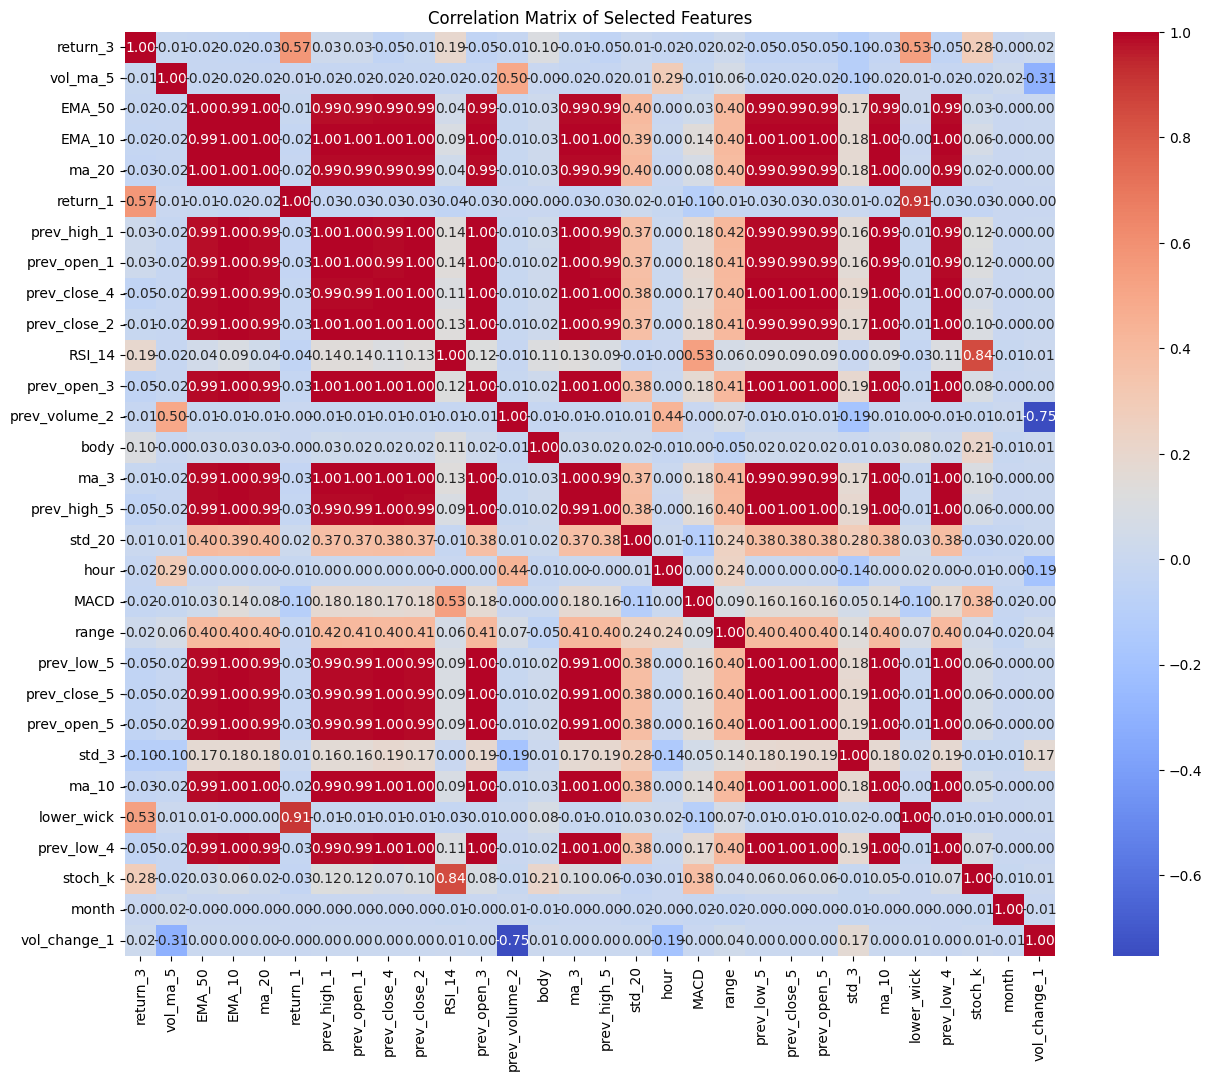

In [9]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Subset your dataframe to final features
X_final = df[final_features]

# Compute correlation matrix
corr_matrix = X_final.corr()

# Visualize
plt.figure(figsize=(15,12))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Matrix of Selected Features")
plt.show()


In [11]:
# Correlation matrix of selected features
corr_matrix = X_final.corr()

# Display
print(corr_matrix)

# Optionally, save to CSV for sharing
corr_matrix.to_csv("correlation_matrix.csv")


               return_3  vol_ma_5    EMA_50    EMA_10     ma_20  return_1  \
return_3       1.000000 -0.011050 -0.016739 -0.023939 -0.028636  0.574420   
vol_ma_5      -0.011050  1.000000 -0.017297 -0.017829 -0.017205 -0.005407   
EMA_50        -0.016739 -0.017297  1.000000  0.993649  0.996858 -0.011417   
EMA_10        -0.023939 -0.017829  0.993649  1.000000  0.996859 -0.024044   
ma_20         -0.028636 -0.017205  0.996858  0.996859  1.000000 -0.018716   
return_1       0.574420 -0.005407 -0.011417 -0.024044 -0.018716  1.000000   
prev_high_1    0.025811 -0.017502  0.985693  0.995596  0.987901 -0.027833   
prev_open_1    0.025039 -0.017956  0.985747  0.995650  0.987976 -0.027820   
prev_close_4  -0.046894 -0.017704  0.988484  0.997678  0.992082 -0.026617   
prev_close_2  -0.010318 -0.017927  0.986775  0.996942  0.989498 -0.026734   
RSI_14         0.193677 -0.016556  0.043424  0.093008  0.038483 -0.041618   
prev_open_3   -0.047626 -0.017636  0.987716  0.997584  0.990911 -0.026881   

In [12]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
import numpy as np

# VIF requires numeric matrix
X_numeric = X_final.select_dtypes(include=[np.number])

vif_data = pd.DataFrame()
vif_data["feature"] = X_numeric.columns
vif_data["VIF"] = [variance_inflation_factor(X_numeric.values, i) for i in range(X_numeric.shape[1])]

# Show features with high VIF (>10 is usually considered high)
print(vif_data.sort_values(by="VIF", ascending=False))


          feature           VIF
3          EMA_10  1.281355e+06
7     prev_open_1  1.277715e+06
6     prev_high_1  1.190343e+06
14           ma_3  8.112843e+05
21   prev_close_5  4.086529e+05
15    prev_high_5  3.983281e+05
20     prev_low_5  3.315483e+05
22    prev_open_5  3.191055e+05
24          ma_10  2.098667e+05
8    prev_close_4  1.540102e+05
26     prev_low_4  1.504822e+05
9    prev_close_2  8.966743e+04
11    prev_open_3  7.094793e+04
4           ma_20  5.955822e+04
2          EMA_50  3.365918e+04
1        vol_ma_5  1.006494e+02
12  prev_volume_2  9.407107e+01
18           MACD  6.638806e+01
10         RSI_14  2.820436e+01
19          range  1.515688e+01
27        stoch_k  1.512601e+01
0        return_3  1.205569e+01
5        return_1  1.007126e+01
13           body  7.790174e+00
25     lower_wick  6.214520e+00
28          month  4.585539e+00
17           hour  4.430349e+00
16         std_20  2.213345e+00
29   vol_change_1  2.210518e+00
23          std_3  1.672535e+00


In [14]:
final_features_reduced = [
    "return_3", "return_1", "RSI_14", "MACD", "stoch_k", "lower_wick",
    "vol_change_1", "hour", "month", "prev_close_1", "EMA_50",
    "range", "body"
]
X = df[final_features_reduced]
y = df["Result"]
# -----------------------------
# Time-series split 70/15/15
# -----------------------------
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, shuffle=False)
X_val, X_test, y_val, y_test   = train_test_split(X_temp, y_temp, test_size=0.5, shuffle=False)

print("Shapes:", X_train.shape, X_val.shape, X_test.shape)

# -----------------------------
# Define numeric columns (month excluded)
# -----------------------------
NUMERIC_COLS = [col for col in final_features_reduced if col != "month"]

# Scale only numeric columns
scaler = StandardScaler()
X_train_numeric_scaled = scaler.fit_transform(X_train[NUMERIC_COLS])
X_val_numeric_scaled   = scaler.transform(X_val[NUMERIC_COLS])
X_test_numeric_scaled  = scaler.transform(X_test[NUMERIC_COLS])

# Keep month as is
X_train_final = np.hstack([X_train_numeric_scaled, X_train[["month"]].values])
X_val_final   = np.hstack([X_val_numeric_scaled,   X_val[["month"]].values])
X_test_final  = np.hstack([X_test_numeric_scaled,  X_test[["month"]].values])

# -----------------------------
# Check shapes
# -----------------------------
print("X_train_final shape:", X_train_final.shape)
print("X_val_final shape:", X_val_final.shape)
print("X_test_final shape:", X_test_final.shape)
print("y_train shape:", y_train.shape)
print("y_val shape:", y_val.shape)
print("y_test shape:", y_test.shape)


Shapes: (18729, 13) (4014, 13) (4014, 13)
X_train_final shape: (18729, 13)
X_val_final shape: (4014, 13)
X_test_final shape: (4014, 13)
y_train shape: (18729,)
y_val shape: (4014,)
y_test shape: (4014,)


In [17]:
# -----------------------------
# 1️⃣ Import libraries
# -----------------------------
import xgboost as xgb
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# -----------------------------
# 2️⃣ Prepare DMatrix (XGBoost's optimized data format)
# -----------------------------
dtrain = xgb.DMatrix(X_train_final, label=y_train)
dval   = xgb.DMatrix(X_val_final, label=y_val)
dtest  = xgb.DMatrix(X_test_final, label=y_test)

# -----------------------------
# 3️⃣ Set parameters
# -----------------------------
params = {
    'objective': 'binary:logistic',  # binary classification
    'eval_metric': 'logloss',         # can also try 'error'
    'eta': 0.05,                      # learning rate
    'max_depth': 5,                    # tree depth
    'subsample': 0.8,                  # row sampling
    'colsample_bytree': 0.8,           # column sampling
    'seed': 42
}

# -----------------------------
# 4️⃣ Train with early stopping
# -----------------------------
evals = [(dtrain, 'train'), (dval, 'val')]

model = xgb.train(
    params=params,
    dtrain=dtrain,
    num_boost_round=1000,
    evals=evals,
    early_stopping_rounds=20,
    verbose_eval=50
)

# -----------------------------
# 5️⃣ Predictions
# -----------------------------
y_pred_prob = model.predict(dtest)
y_pred = (y_pred_prob > 0.5).astype(int)

# -----------------------------
# 6️⃣ Evaluation
# -----------------------------
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))


[0]	train-logloss:0.69212	val-logloss:0.69351
[30]	train-logloss:0.67813	val-logloss:0.69464
Accuracy: 0.512954658694569

Classification Report:
               precision    recall  f1-score   support

           0       0.46      0.31      0.37      1861
           1       0.54      0.69      0.60      2153

    accuracy                           0.51      4014
   macro avg       0.50      0.50      0.49      4014
weighted avg       0.50      0.51      0.50      4014


Confusion Matrix:
 [[ 581 1280]
 [ 675 1478]]


In [28]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# Use your X_train_final, X_val_final, X_test_final
input_dim = X_train_final.shape[1]

# Simple Dense model
model = Sequential([
    Dense(64, activation='relu', input_dim=input_dim),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer=Adam(0.001), loss='binary_crossentropy', metrics=['accuracy'])

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(
    X_train_final, y_train,
    validation_data=(X_val_final, y_val),
    epochs=30,
    batch_size=32,
    callbacks=[early_stop],
    verbose=2
)

# Evaluate
y_pred_prob = model.predict(X_test_final)
y_pred = (y_pred_prob > 0.5).astype(int)

from sklearn.metrics import accuracy_score
print("DL Model Accuracy:", accuracy_score(y_test, y_pred))


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
586/586 - 4s - 7ms/step - accuracy: 0.5065 - loss: 0.7018 - val_accuracy: 0.5037 - val_loss: 0.6960
Epoch 2/30
586/586 - 4s - 7ms/step - accuracy: 0.5089 - loss: 0.6959 - val_accuracy: 0.5017 - val_loss: 0.6951
Epoch 3/30
586/586 - 2s - 4ms/step - accuracy: 0.5068 - loss: 0.6943 - val_accuracy: 0.5025 - val_loss: 0.6944
Epoch 4/30
586/586 - 2s - 3ms/step - accuracy: 0.5126 - loss: 0.6930 - val_accuracy: 0.4958 - val_loss: 0.6973
Epoch 5/30
586/586 - 2s - 3ms/step - accuracy: 0.5198 - loss: 0.6918 - val_accuracy: 0.4953 - val_loss: 0.6985
Epoch 6/30
586/586 - 3s - 5ms/step - accuracy: 0.5199 - loss: 0.6917 - val_accuracy: 0.4920 - val_loss: 0.6949
Epoch 7/30
586/586 - 4s - 7ms/step - accuracy: 0.5240 - loss: 0.6913 - val_accuracy: 0.5057 - val_loss: 0.6951
Epoch 8/30
586/586 - 2s - 3ms/step - accuracy: 0.5259 - loss: 0.6915 - val_accuracy: 0.5035 - val_loss: 0.6958
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
DL Model Accuracy: 0.5343796711509716


In [29]:

from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

y_pred_classes = (y_pred > 0.5).astype(int)

cm = confusion_matrix(y_test, y_pred_classes)
print("Confusion Matrix:\n", cm)


cr = classification_report(y_test, y_pred_classes)
print("\nClassification Report:\n", cr)


acc = accuracy_score(y_test, y_pred_classes)
print("\nAccuracy:", acc)


Confusion Matrix:
 [[ 463 1398]
 [ 471 1682]]

Classification Report:
               precision    recall  f1-score   support

           0       0.50      0.25      0.33      1861
           1       0.55      0.78      0.64      2153

    accuracy                           0.53      4014
   macro avg       0.52      0.52      0.49      4014
weighted avg       0.52      0.53      0.50      4014


Accuracy: 0.5343796711509716


In [35]:
# -----------------------------
# 1️⃣ Imports
# -----------------------------
import numpy as np
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import keras_tuner as kt

# -----------------------------
# 2️⃣ Prepare data (example: use X_train_final, X_val_final, X_test_final)
# -----------------------------
# Assume X_train_final, X_val_final, X_test_final, y_train, y_val, y_test are already prepared
# from your previous XGBoost pipeline

# -----------------------------
# 3️⃣ Define model builder for hyperparameter tuning
# -----------------------------
def build_model(hp):
    model = Sequential()

    # First hidden layer
    model.add(Dense(
        units=hp.Int('units1', min_value=16, max_value=128, step=16),
        activation=hp.Choice('act1', ['relu', 'tanh']),
        input_shape=(X_train_final.shape[1],)
    ))
    model.add(Dropout(hp.Float('dropout1', 0.0, 0.5, step=0.1)))

    # Optional second hidden layer
    if hp.Boolean('second_layer'):
        model.add(Dense(
            units=hp.Int('units2', 16, 64, step=16),
            activation=hp.Choice('act2', ['relu', 'tanh'])
        ))
        model.add(Dropout(hp.Float('dropout2', 0.0, 0.5, step=0.1)))

    # Output layer
    model.add(Dense(1, activation='sigmoid'))

    # Compile model
    model.compile(
        optimizer=keras.optimizers.Adam(
            hp.Float('learning_rate', 1e-4, 1e-2, sampling='log')
        ),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

    return model

# -----------------------------
# 4️⃣ Setup Keras Tuner
# -----------------------------
tuner = kt.RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=20,          # you can increase if you have more time
    executions_per_trial=1,
    overwrite=True,
    directory='dl_tuning',
    project_name='gold_direction'
)

# -----------------------------
# 5️⃣ Run hyperparameter search
# -----------------------------
tuner.search(
    X_train_final, y_train,
    validation_data=(X_val_final, y_val),
    epochs=30,
    batch_size=32,        # fixed batch size for tuning
    verbose=2
)

# -----------------------------
# 6️⃣ Retrieve best model
# -----------------------------
best_model = tuner.get_best_models(num_models=1)[0]

# -----------------------------
# 7️⃣ Evaluate on test data
# -----------------------------
y_pred_prob = best_model.predict(X_test_final)
y_pred = (y_pred_prob > 0.5).astype(int)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))


Trial 20 Complete [00h 00m 52s]
val_accuracy: 0.5174389481544495

Best val_accuracy So Far: 0.5251619219779968
Total elapsed time: 00h 21m 13s
 41/126 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 

/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 10 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Accuracy: 0.49302441454907825

Classification Report:
               precision    recall  f1-score   support

           0       0.47      0.67      0.55      1861
           1       0.54      0.34      0.42      2153

    accuracy                           0.49      4014
   macro avg       0.51      0.51      0.48      4014
weighted avg       0.51      0.49      0.48      4014


Confusion Matrix:
 [[1256  605]
 [1430  723]]
